In [14]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
# can alternatively use addfiles to spark init in nb_spark
from src import EDA, ModelEvaluation, Preprocess, Split, TimeDecorator
%load_ext autoreload
%autoreload 2

spark_session = SparkSession.builder.getOrCreate()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
@TimeDecorator.timeit
def create_dataset(df, min_games_played=0, min_users_for_game=0, game_split_train=.3):
    df = EDA.get_filtered_user_item(df, min_games_played=min_games_played, min_users_for_game=min_users_for_game)
    pandas_train_test = Split.PandasTrainTest(df, seed=1)
    k_fold_dfs = pandas_train_test.get_k_folds(5, game_split_train=game_split_train)
    # TODO instead of tuple, make class
    print('first train test split size: {}, {} '.format(k_fold_dfs[0][0].shape[0], k_fold_dfs[0][1].shape[0]))
    sparkified_k_fold_dfs = [(spark_session.createDataFrame(a), spark_session.createDataFrame(b)) for a, b in k_fold_dfs]
    return sparkified_k_fold_dfs

In [26]:
def dcg_at_k(scores, k):
    """
    Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float
    """
    r = np.asfarray(scores)[:k]
    if r.size:
        # item 1 and 2 have same weights
        # return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        # more emphasis on first rank
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(scores, k):
    """
    Normalized Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float from 0 to 1
    """
    dcg_max = dcg_at_k(sorted(scores, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(scores, k) / dcg_max

def get_rdd_ndcg(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    rdd_ndcg = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda all_data, val: all_data + val) \
        .map(lambda kv: sorted(kv[1], key=lambda x: x[1], reverse=True)) \
        .map(lambda v: ndcg_at_k(np.array(v)[:, 0], top_n)) \
        .sum()
    return rdd_ndcg

def fit_and_predict_kfold(model, train_test_dfs):
    prediction_rdds = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        prediction_rdd = predictions.rdd
        prediction_rdds.append(prediction_rdd)
    return prediction_rdds

# idea! Compare dcg to random shuffle.  Comparing dcg or ndcg shouldnt change the output.
def idcg_at_k(scores, k):
    """
    Increased Discounted cumulative gain
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float
    """
    shuffled = random.sample(list(scores), len(scores))
    dcg_random = dcg_at_k(shuffled, k)
    if not dcg_random:
        return 0.
    return dcg_at_k(scores, k) / dcg_random

def get_rdd_idcg(rdd, top_n=5, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    rdd_idcg = rdd \
        .map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda all_data, val: all_data + val) \
        .map(lambda kv: sorted(kv[1], key=lambda x: x[1], reverse=True)) \
        .map(lambda v: idcg_at_k(np.array(v)[:, 0], top_n)) \
        .sum()
    return rdd_idcg

@TimeDecorator.timeit
def get_idcg(dataset, als_model):
    # for graphing its fine, but need to divide by number of users to get a stat that can be compared
    k_fold_prediction_rdds = fit_and_predict_kfold(als_model, dataset)
    idcgs = [get_rdd_idcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
    for i in range(len(k_fold_prediction_rdds)):
        # the counts are almost always the same for each fold... but its a fast operation
        user_count = dataset[i][1].groupBy('uid').count().count()
        idcgs[i] = idcgs[i] / user_count
    test_count = dataset[0][1].groupBy('uid').count().count()
    print('num test users: ', test_count)
    idcg = sum(idcgs) / len(idcgs)
    print('idcg: ', idcg)
    return idcg
    
@TimeDecorator.timeit
def get_ndcg(dataset, als_model):
    # for graphing its fine, but need to divide by number of users to get a stat that can be compared
    k_fold_prediction_rdds = fit_and_predict_kfold(als_model, dataset)
    ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
    for i in range(len(k_fold_prediction_rdds)):
        # the counts are almost always the same for each fold... but its a fast operation
        user_count = dataset[i][1].groupBy('uid').count().count()
        ndcgs[i] = ndcgs[i] / user_count
    test_count = dataset[0][1].groupBy('uid').count().count()
    print('num test users: ', test_count)
    ndcg = sum(ndcgs) / len(ndcgs)
    print('ndcg: ', ndcg)
    return ndcg

In [20]:
# need holdout users.  Hold out 10%.
steam_df = EDA.load_200k()
preprocessor = Preprocess.PandasALSPreprocessor(steam_df)
preprocessor.add_item_ids()
preprocessor.add_min_max()
preprocessor.keep_standard_columns()
steam_df = preprocessor.get_df()
pandas_train_test = Split.PandasTrainTest(steam_df, seed=1)
train_val, holdout_test = pandas_train_test.user_only_split(user_split_train=.9)
print('split sizes: ', (train_val.shape[0], holdout_test.shape[0]))
train_val.head(2)

split sizes:  (62791, 7698)


,playtime_min_max,game_uid,game_name,uid,playtime
1,0.412256,0,The Elder Scrolls V Skyrim,151603712,273.0
3,0.414122,1,Fallout 4,151603712,87.0


In [21]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10
);

In [25]:
# int((4 + 1) * .4) => 2.  meaning if 4 games are played, 2 go in train and 2 go in test
base_case = create_dataset(train_val, min_games_played=0, min_users_for_game=0, game_split_train=.4)
get_idcg(base_case, als_model)

first train test split size: 54576, 8215 
'create_dataset'  19285.07 ms
'fit_and_predict_kfold'  10004.86 ms
num test users:  2043
idcg:  1.0803711266310476
'get_idcg'  48776.34 ms


1.0803711266310476

## Cold Start for Users

In [27]:
min_games_played_datasets1 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0, game_split_train=.4) for i in range(1,10)]

first train test split size: 54576, 8215 
'create_dataset'  18792.19 ms
first train test split size: 50238, 6652 
'create_dataset'  14507.88 ms
first train test split size: 47383, 6993 
'create_dataset'  13743.94 ms
first train test split size: 46853, 5873 
'create_dataset'  12984.33 ms
first train test split size: 45541, 5839 
'create_dataset'  12719.83 ms
first train test split size: 44085, 5925 
'create_dataset'  12293.11 ms
first train test split size: 42892, 5694 
'create_dataset'  12015.86 ms
first train test split size: 42320, 5447 
'create_dataset'  11333.51 ms
first train test split size: 40823, 6016 
'create_dataset'  10926.37 ms


In [29]:
# prediction vs random_prediction dcg
min_games_results1 = [get_idcg(dataset, als_model) for dataset in min_games_played_datasets1]

num test users:  2043
idcg:  0.6734134553775885
'get_idcg'  49580.97 ms
num test users:  863
idcg:  1.662884984463128
'get_idcg'  44690.23 ms
num test users:  624
idcg:  1.9070741484286386
'get_idcg'  42342.08 ms
num test users:  510
idcg:  1.9927132395194591
'get_idcg'  40201.29 ms
num test users:  440
idcg:  2.316009308830618
'get_idcg'  40643.47 ms
num test users:  385
idcg:  2.755466791241388
'get_idcg'  40974.40 ms
num test users:  343
idcg:  2.704764617023603
'get_idcg'  39371.44 ms
num test users:  315
idcg:  2.8061222453641044
'get_idcg'  39496.11 ms
num test users:  292
idcg:  3.35668326657907
'get_idcg'  40060.19 ms


In [30]:
min_games_played_datasets2 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(10,18)]

first train test split size: 38833, 6926 
'create_dataset'  10916.01 ms
first train test split size: 38194, 6564 
'create_dataset'  10684.88 ms
first train test split size: 37895, 5936 
'create_dataset'  11037.01 ms
first train test split size: 37177, 5922 
'create_dataset'  10219.37 ms
first train test split size: 36543, 5431 
'create_dataset'  9823.91 ms
first train test split size: 35763, 5520 
'create_dataset'  9654.40 ms
first train test split size: 34761, 5472 
'create_dataset'  9328.54 ms
first train test split size: 33951, 5352 
'create_dataset'  9200.70 ms


In [33]:
# prediction vs random_prediction ndcg
min_games_results2 = [get_idcg(dataset, als_model) for dataset in min_games_played_datasets2]

num test users:  268
idcg:  3.1720203811517296
'get_idcg'  38806.26 ms
num test users:  248
idcg:  3.5964406572761405
'get_idcg'  40322.63 ms
num test users:  231
idcg:  3.0001893686401897
'get_idcg'  38490.25 ms
num test users:  219
idcg:  3.8430422189609343
'get_idcg'  42409.81 ms
num test users:  203
idcg:  5.395111102760337
'get_idcg'  38220.05 ms
num test users:  192
idcg:  3.6300313432250717
'get_idcg'  38505.43 ms
num test users:  178
idcg:  3.842253227325609
'get_idcg'  37115.67 ms
num test users:  167
idcg:  3.7012353986512787
'get_idcg'  38975.77 ms


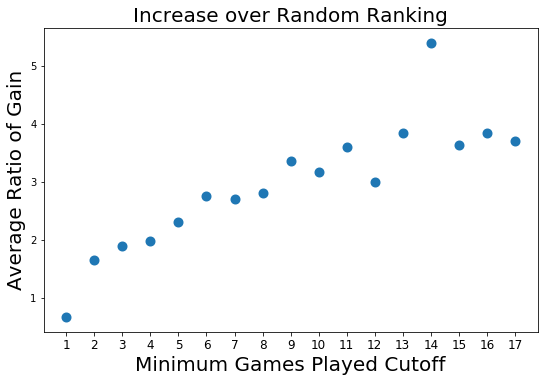

In [78]:
user_increases = min_games_results1 + min_games_results2
fig, ax = plt.subplots()
ax.scatter(list(range(1,18)), user_increases, linewidths=4)
ax.set_xticks(list(range(1,18)))
ax.set_title('Increase over Random Ranking', fontsize=20)
ax.set_xlabel('Minimum Games Played Cutoff', fontsize=20)
ax.set_ylabel('Average Ratio of Gain', fontsize=20)
ax.set_xticklabels(list(range(1,18)), fontsize=12)
fig.tight_layout()
fig.set_size_inches(8,6)
fig.show()
# fig.savefig('../figures/increase_games_played_6.png')

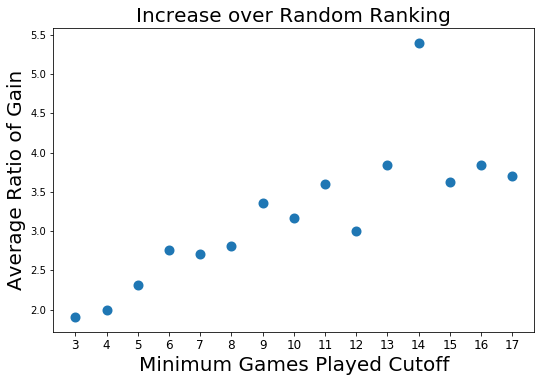

In [65]:
user_increases = min_games_results1[2:] + min_games_results2
fig, ax = plt.subplots()
ax.scatter(list(range(3,18)), user_increases, linewidths=4)
ax.set_xticks(list(range(3,18)))
ax.set_title('Increase over Random Ranking', fontsize=20)
ax.set_xlabel('Minimum Games Played Cutoff', fontsize=20)
ax.set_ylabel('Average Ratio of Gain', fontsize=20)
ax.set_xticklabels(list(range(3,18)), fontsize=12)
fig.tight_layout()
fig.set_size_inches(8,6)
fig.show()
# fig.savefig('../figures/increase_games_played_6_clipped.png')

### Compare to User Dropoff

Number of unique users:  11350


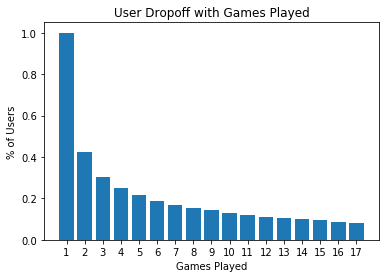

In [149]:
game_counts = steam_df.groupby('uid').count()
print('Number of unique users: ', game_counts.shape[0])

range_max = 18
counts = [game_counts[game_counts['game_name'] >= i].shape[0] for i in range (1, range_max)]
percent_counts = [count / counts[0] for count in counts]

fig, ax = plt.subplots()
ax.bar(list(range(1, range_max)), percent_counts)
ax.set_xticks(list(range(1,18)))
ax.set_title('User Dropoff with Games Played')
ax.set_xlabel('Games Played')
ax.set_ylabel('% of Users')
fig.show()
# fig.savefig('../figures/user_dropoff.png')

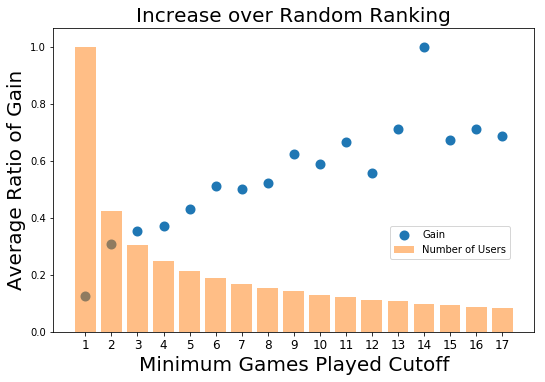

In [150]:
user_increases = min_games_results1 + min_games_results2
max_user_increases = max(user_increases)
user_increases = [ui / max_user_increases for ui in user_increases]
fig, ax = plt.subplots()
ax.scatter(list(range(1,18)), user_increases, linewidths=4)
ax.bar(list(range(1, 18)), percent_counts, alpha = 0.5)
ax.set_xticks(list(range(1,18)))
ax.set_title('Increase over Random Ranking', fontsize=20)
ax.set_xlabel('Minimum Games Played Cutoff', fontsize=20)
ax.set_ylabel('Average Ratio of Gain', fontsize=20)
ax.set_xticklabels(list(range(1,18)), fontsize=12)
ax.legend(['Gain', 'Number of Users'], loc=(.7,.24))
fig.tight_layout()
fig.set_size_inches(8,6)
fig.show()
# fig.savefig('../figures/increase_games_played_vs_dropoff.png')

In [173]:
steam_df_big = spark_session.read.json("../data/steam-800k.jsonl", mode='DROPMALFORMED')
steam_df_big = steam_df_big.toPandas()

Number of unique users:  11350


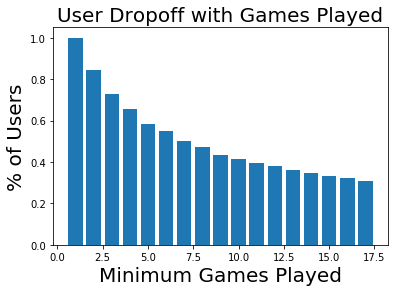

In [177]:
game_counts_big = steam_df_big.groupby('user_id').count()
print('Number of unique users: ', game_counts.shape[0])

range_max = 18
big_counts = [game_counts_big[game_counts_big['game_id'] >= i].shape[0] for i in range (1, range_max)]
percent_counts_big = [count / big_counts[0] for count in big_counts]

fig, ax = plt.subplots()
ax.bar(list(range(1, range_max)), percent_counts_big)
ax.set_title('User Dropoff with Games Played', fontsize=20)
ax.set_xlabel('Minimum Games Played', fontsize=20)
ax.set_ylabel('% of Users', fontsize=20)
fig.show()
fig.savefig('../figures/user_dropoff_big.png')

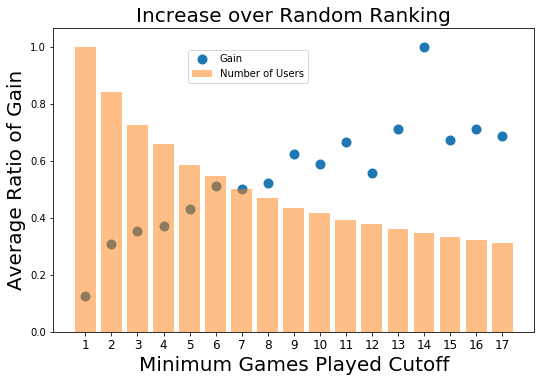

In [178]:
user_increases = min_games_results1 + min_games_results2
max_user_increases = max(user_increases)
user_increases = [ui / max_user_increases for ui in user_increases]
fig, ax = plt.subplots()
ax.scatter(list(range(1,18)), user_increases, linewidths=4)
ax.bar(list(range(1, range_max)), percent_counts_big, alpha = 0.5)
ax.set_xticks(list(range(1,18)))
ax.set_title('Increase over Random Ranking', fontsize=20)
ax.set_xlabel('Minimum Games Played Cutoff', fontsize=20)
ax.set_ylabel('Average Ratio of Gain', fontsize=20)
ax.set_xticklabels(list(range(1,18)), fontsize=12)
ax.legend(['Gain', 'Number of Users'], loc=(.28,.82))
fig.tight_layout()
fig.set_size_inches(8,6)
fig.show()
# fig.savefig('../figures/increase_games_played_vs_dropoff_big.png')

## Final Model

In [120]:
final_model_dataset = create_dataset(train_val, min_games_played=6, min_users_for_game=2, game_split_train=.4)
final_model_results = get_idcg(final_model_dataset, als_model)

first train test split size: 42184, 5862 
'create_dataset'  11781.18 ms
num test users:  385
idcg:  2.873005281033996
'get_idcg'  38145.55 ms


In [121]:
user_counts = final_model_dataset[0][0].groupBy('uid').count().count() + final_model_dataset[0][1].groupBy('uid').count().count()
print('Using {}% of Original Users'.format(round((user_counts / 11350) * 100, 2)))

Using 20.34% of Original Users


In [122]:
print('Final Model Test Increase: {}x'.format(round(final_model_results, 2)))

Final Model Test Increase: 2.87x


#### Test metric on holdout validation set

In [195]:
final_model_dataset = create_dataset(train_val, min_games_played=6, min_users_for_game=2, game_split_train=.4)
k_fold_prediction_rdds = fit_and_predict_kfold(als_model, final_model_dataset)
ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
ndcg = sum(ndcgs) / len(ndcgs)
random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
final_model_results = (ndcg, random_ndcg)
final_model_results

first train test split size: 42184, 5862 
'create_dataset'  12196.98 ms


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 13265.0 failed 1 times, most recent failure: Lost task 0.0 in stage 13265.0 (TID 167371, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/sql/types.py", line 1486, in __getitem__
    idx = self.__fields__.index(item)
ValueError: 'random_prediction' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 1842, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-26-dbe103f658cf>", line 35, in <lambda>
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/sql/types.py", line 1491, in __getitem__
    raise ValueError(item)
ValueError: random_prediction

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:395)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2043)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2062)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2087)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:458)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/sql/types.py", line 1486, in __getitem__
    idx = self.__fields__.index(item)
ValueError: 'random_prediction' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 2423, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/pyspark/rdd.py", line 1842, in combineLocally
    merger.mergeValues(iterator)
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-26-dbe103f658cf>", line 35, in <lambda>
  File "/usr/local/Cellar/apache-spark/2.2.0/libexec/python/lib/pyspark.zip/pyspark/sql/types.py", line 1491, in __getitem__
    raise ValueError(item)
ValueError: random_prediction

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:395)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [123]:
final_model_training = EDA.get_filtered_user_item(train_val, min_games_played=6, min_users_for_game=2)
final_model_holdout = EDA.get_filtered_user_item(holdout_test, min_games_played=6, min_users_for_game=2)
final_splitter = Split.PandasTrainTest(final_model_holdout)
holdout_train_games, holdout_test_games  = final_splitter.user_games_split(final_model_holdout, game_split_train=.4)
# How valuable is this kind of validation here?  Should we have added train games to the other models?
final_model_training = final_model_training.append(holdout_train_games)

In [124]:
final_model_training_spark_dataset = spark_session.createDataFrame(final_model_training)
holdout_test_spark_dataset = spark_session.createDataFrame(holdout_test_games)
validation_idcg = get_idcg([(final_model_training_spark_dataset, holdout_test_spark_dataset)], als_model)
print('Validation Holdout Test Increase: {}x'.format(round(validation_idcg, 2)))

num test users:  205
idcg:  3.042358006714265
'get_idcg'  7203.75 ms
Validation Holdout Test Increase: 3.04x


In [117]:
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_min_max") \
    .setPredictionCol("prediction")
rmse = evaluator.evaluate(final_test_predictions)
random_evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_min_max") \
    .setPredictionCol("random_prediction")
random_rmse = random_evaluator.evaluate(final_test_predictions)

In [ ]:
final_test_rmse_increase = ((random_rmse / rmse) - 1) * 100
print('Final Model Random RMSE Increase: {}%'.format(round(final_test_rmse_increase, 3)))

In [111]:
min_games_played_datasets2[0]

[(DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double],
  DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double]),
 (DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double],
  DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double]),
 (DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double],
  DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double]),
 (DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double],
  DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double]),
 (DataFrame[playtime_min_max: double, game_uid: bigint, game_name: string, uid: bigint, playtime: double],
  DataFrame[playtime_min_max: dou

In [ ]:
final_test_increase = ((final_test_ndcg / final_test_random_ndcg) - 1) * 100
print('Final Model Validation Increase: {}%'.format(round(final_test_increase, 3)))